# Player Statistics Analysis

This notebook performs comprehensive analysis of player performance data, including:
- Basic statistics
- WOWY impact analysis
- Trend regression over stints
- Visualization of trends

Each section can be run independently.

In [36]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Define data directory
DATA_DIR = 'data/'

## Section 1: Load the datasets

In [37]:
# Load the datasets
player_data = pd.read_csv(DATA_DIR + 'player_data.csv')
stint_data = pd.read_csv(DATA_DIR + 'stint_data.csv')

# Add original order and sort by game_id and order
stint_data['original_order'] = range(len(stint_data))
stint_data = stint_data.sort_values(['game_id', 'original_order'])
stint_data['stint_number'] = stint_data.groupby('game_id').cumcount() + 1

# Function to extract team from player name
def extract_team(player):
    return '_'.join(player.split('_')[:-1])

# Prepare player data
player_data['team'] = player_data['player'].apply(extract_team)

print("Data loaded successfully")
print(f"Players: {len(player_data)}")
print(f"Stints: {len(stint_data)}")

Data loaded successfully
Players: 144
Stints: 7448


## Section 2: Expand stint data to individual player records

In [38]:
# Create a list to hold the expanded data
expanded_rows = []

# For each stint, expand to individual players
for _, row in stint_data.iterrows():
    game_id = row['game_id']
    h_team = row['h_team']
    a_team = row['a_team']
    minutes = row['minutes']
    h_goals = row['h_goals']
    a_goals = row['a_goals']
    stint_number = row['stint_number']
    
    # Home players
    for i in range(1, 5):
        player = row[f'home{i}']
        expanded_rows.append({
            'game_id': game_id,
            'player': player,
            'team': h_team,
            'minutes': minutes,
            'goals_for': h_goals,
            'goals_against': a_goals,
            'stint_number': stint_number
        })
    
    # Away players
    for i in range(1, 5):
        player = row[f'away{i}']
        expanded_rows.append({
            'game_id': game_id,
            'player': player,
            'team': a_team,
            'minutes': minutes,
            'goals_for': a_goals,
            'goals_against': h_goals,
            'stint_number': stint_number
        })

# Create expanded dataframe
expanded_df = pd.DataFrame(expanded_rows)

# Sort expanded_df and assign player_stint_number per game
expanded_df = expanded_df.sort_values(['player', 'game_id', 'stint_number'])
expanded_df['player_stint_number'] = expanded_df.groupby(['player', 'game_id']).cumcount() + 1

print(f"Expanded data shape: {expanded_df.shape}")

Expanded data shape: (59584, 8)


## Section 3: Compute stint goal differentials and number of stints

In [39]:
# Compute goal differentials for each player's stints
stint_gd_raw = defaultdict(lambda: defaultdict(list))
for _, row in expanded_df.iterrows():
    player = row['player']
    stint_num = row['player_stint_number']
    gd = row['goals_for'] - row['goals_against']
    if stint_num <= 16:
        stint_gd_raw[player][stint_num].append(gd)

# Average the GDs for each stint number per player
stint_gd = {}
for player in stint_gd_raw:
    stint_gd[player] = {}
    for stint_num in stint_gd_raw[player]:
        stint_gd[player][stint_num] = np.mean(stint_gd_raw[player][stint_num])

# Compute max stint number per player
number_of_stints = {}
for player in stint_gd:
    number_of_stints[player] = max(stint_gd[player].keys()) if stint_gd[player] else 0

print("Stint goal differentials computed")

Stint goal differentials computed


## Section 4: Calculate trend regression for each player

In [40]:
# Calculate trend regression for each player
trend_dict = {}
for player in player_data['player']:
    gds = []
    stint_nums = []
    num_stints = number_of_stints.get(player, 0)
    for i in range(1, num_stints + 1):
        if i in stint_gd[player]:
            gds.append(stint_gd[player][i])
            stint_nums.append(i)
    
    if len(gds) >= 2:
        slope, intercept = np.polyfit(stint_nums, gds, 1)
        trend_dict[player] = {'slope': slope, 'intercept': intercept}
    else:
        trend_dict[player] = {'slope': None, 'intercept': None}

print("Trend regressions calculated")

Trend regressions calculated


## Section 5: Aggregate goals and minutes per player

In [41]:
# Aggregate goals and minutes per player
player_stats = expanded_df.groupby('player').agg({
    'goals_for': 'sum',
    'goals_against': 'sum',
    'minutes': 'sum'
}).reset_index()

# Calculate number of games per player
num_games_series = expanded_df.groupby('player')['game_id'].nunique()
player_stats['num_games'] = player_stats['player'].map(num_games_series)

# Calculate average minutes per game
player_stats['avg_minutes_per_game'] = player_stats['minutes'] / player_stats['num_games']

# Merge with player ratings
player_stats = player_stats.merge(player_data[['player', 'rating']], on='player', how='left')

# Calculate plus/minus per minute
player_stats['plus_minus_per_min'] = (player_stats['goals_for'] - player_stats['goals_against']) / player_stats['minutes']

print("Basic player statistics calculated")

Basic player statistics calculated


## Section 6: Calculate WOWY impact

In [42]:
# Initialize stats dictionaries
with_stats = defaultdict(lambda: defaultdict(lambda: {'gf': 0, 'ga': 0, 'min': 0}))
total_stats = defaultdict(lambda: {'gf': 0, 'ga': 0, 'min': 0})

# First, compute total stats for each player
for _, row in stint_data.iterrows():
    h_team = row['h_team']
    a_team = row['a_team']
    h_gf = row['h_goals']
    h_ga = row['a_goals']
    a_gf = row['a_goals']
    a_ga = row['h_goals']
    minutes = row['minutes']
    
    lineup_h = [row[f'home{i}'] for i in range(1, 5)]
    lineup_a = [row[f'away{i}'] for i in range(1, 5)]
    
    for player in lineup_h:
        total_stats[player]['gf'] += h_gf
        total_stats[player]['ga'] += h_ga
        total_stats[player]['min'] += minutes
    
    for player in lineup_a:
        total_stats[player]['gf'] += a_gf
        total_stats[player]['ga'] += a_ga
        total_stats[player]['min'] += minutes

# Compute with_stats for each pair
for _, row in stint_data.iterrows():
    h_team = row['h_team']
    a_team = row['a_team']
    h_gf = row['h_goals']
    h_ga = row['a_goals']
    a_gf = row['a_goals']
    a_ga = row['h_goals']
    minutes = row['minutes']
    
    lineup_h = [row[f'home{i}'] for i in range(1, 5)]
    lineup_a = [row[f'away{i}'] for i in range(1, 5)]
    
    for i in lineup_h:
        for j in lineup_h:
            if i != j:
                with_stats[i][j]['gf'] += h_gf
                with_stats[i][j]['ga'] += h_ga
                with_stats[i][j]['min'] += minutes
    
    for i in lineup_a:
        for j in lineup_a:
            if i != j:
                with_stats[i][j]['gf'] += a_gf
                with_stats[i][j]['ga'] += a_ga
                with_stats[i][j]['min'] += minutes

# Compute without_stats as total - with
without_stats = defaultdict(lambda: defaultdict(lambda: {'gf': 0, 'ga': 0, 'min': 0}))
for i in player_data['player']:
    for j in player_data['player']:
        if i != j and player_data[player_data['player'] == i]['team'].iloc[0] == player_data[player_data['player'] == j]['team'].iloc[0]:
            without_stats[i][j]['gf'] = total_stats[j]['gf'] - with_stats[i][j]['gf']
            without_stats[i][j]['ga'] = total_stats[j]['ga'] - with_stats[i][j]['ga']
            without_stats[i][j]['min'] = total_stats[j]['min'] - with_stats[i][j]['min']

# Compute WOWY for each player
wowy_dict = {}
for i in player_data['player']:
    team_i = player_data[player_data['player'] == i]['team'].iloc[0]
    teammates = [j for j in player_data['player'] if player_data[player_data['player'] == j]['team'].iloc[0] == team_i and j != i]
    
    deltas = []
    weights = []
    for j in teammates:
        gf_with = with_stats[i][j]['gf']
        ga_with = with_stats[i][j]['ga']
        gf_without = without_stats[i][j]['gf']
        ga_without = without_stats[i][j]['ga']
        min_with = with_stats[i][j]['min']
        
        if gf_with + ga_with > 0:
            gf_pct_with = gf_with / (gf_with + ga_with)
        else:
            gf_pct_with = 0
        
        if gf_without + ga_without > 0:
            gf_pct_without = gf_without / (gf_without + ga_without)
        else:
            gf_pct_without = 0
        
        delta = gf_pct_with - gf_pct_without
        weight = min_with  # weight by shared minutes
        
        if min_with > 0:  # only if they played together
            deltas.append(delta)
            weights.append(weight)
    
    if weights:
        wowy = sum(d * w for d, w in zip(deltas, weights)) / sum(weights)
    else:
        wowy = 0
    
    wowy_dict[i] = wowy

# Add WOWY to player_stats
player_stats['wowy'] = player_stats['player'].map(wowy_dict)

print("WOWY impact calculated")

WOWY impact calculated


## Section 7: Add all stats to player_data

In [43]:
# Add stint data to player_data
player_data['number_of_stints'] = player_data['player'].map(number_of_stints).fillna(0)
for i in range(1, 17):
    player_data[f'stint{i}_gd'] = player_data['player'].map(lambda p: stint_gd[p].get(i, None))

# Add trend columns
player_data['trend_slope'] = player_data['player'].map(lambda p: trend_dict[p]['slope'])
player_data['trend_intercept'] = player_data['player'].map(lambda p: trend_dict[p]['intercept'])

# Add player_stats columns to player_data
missing_cols = [col for col in ['plus_minus_per_min', 'avg_minutes_per_game', 'wowy'] if col not in player_data.columns]
if missing_cols:
    player_data = player_data.merge(player_stats[['player'] + missing_cols], on='player', how='left')

# Remove any duplicate columns with .1 suffix
player_data = player_data.loc[:, ~player_data.columns.str.contains(r'\.1$')]

# Remove trend slope and intercept columns
player_data = player_data.drop(columns=['trend_slope', 'trend_intercept'], errors='ignore')

print(f"Final player_data shape: {player_data.shape}")
print("All statistics added to player_data")

Final player_data shape: (144, 23)
All statistics added to player_data


## Section 8: Plot trend lines for Canadian players

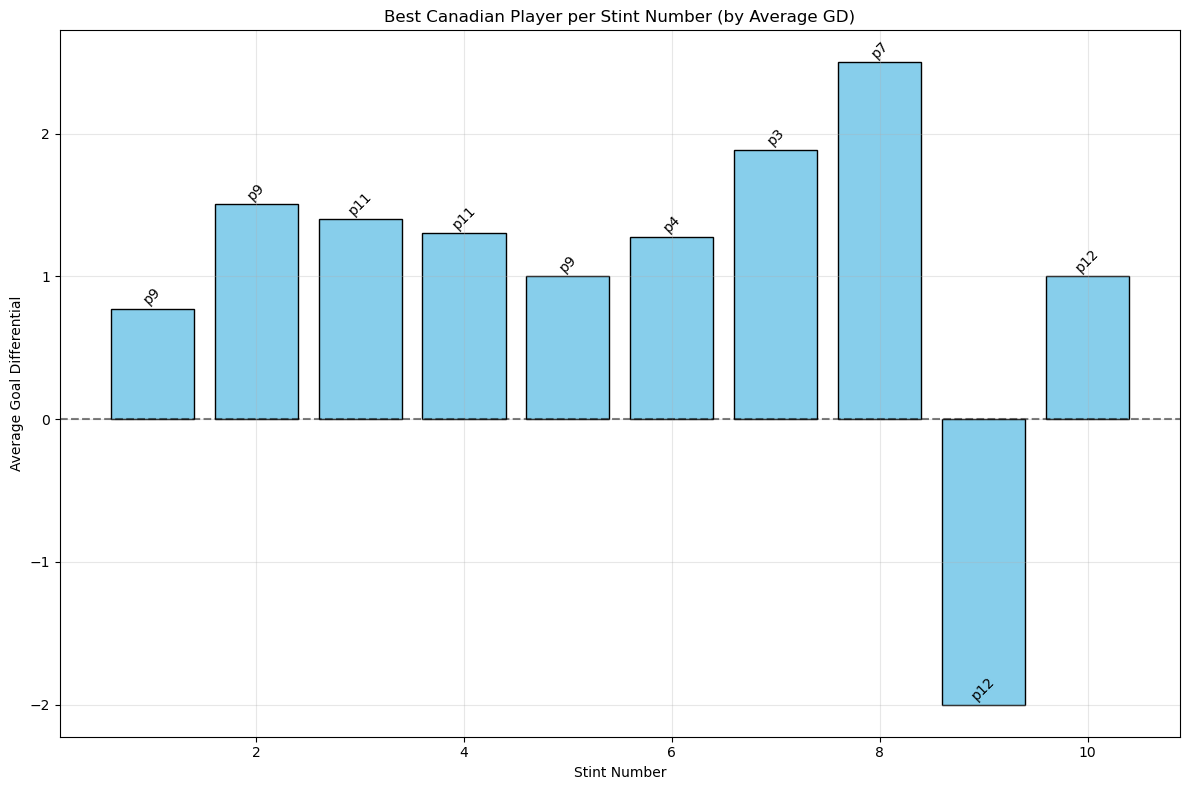

Best player per stint plot displayed in notebook


In [44]:
# Plot best Canadian player per stint number
canada_players = player_data[player_data['team'] == 'Canada']

# Collect data for best player per stint
stint_nums = sorted(set().union(*[stint_gd[player].keys() for player in canada_players['player']]))
best_players = {}
best_gds = {}

for stint in stint_nums:
    stint_data = {player: stint_gd[player].get(stint, float('-inf')) for player in canada_players['player']}
    best_player = max(stint_data, key=stint_data.get)
    best_gd = stint_data[best_player]
    if best_gd != float('-inf'):
        best_players[stint] = best_player
        best_gds[stint] = best_gd

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(best_players.keys(), best_gds.values(), color='skyblue', edgecolor='black')

# Add player names on bars
for bar, stint in zip(bars, best_players.keys()):
    player_name = best_players[stint].split('_')[-1]  # Get last part of name for brevity
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, player_name, 
            ha='center', va='bottom', fontsize=10, rotation=45)

ax.set_xlabel('Stint Number')
ax.set_ylabel('Average Goal Differential')
ax.set_title('Best Canadian Player per Stint Number (by Average GD)')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Best player per stint plot displayed in notebook")

## Section 9: Save updated player_data

In [45]:
# Save updated player_data
player_data.to_csv(DATA_DIR + 'player_data.csv', index=False)

print("Updated player_data.csv saved with all statistics")

Updated player_data.csv saved with all statistics
